In [4]:
!pip install git+https://github.com/facebookresearch/sam2.git
!pip install -U transformers accelerate opencv-python pillow scipy tqdm

  Cloning https://github.com/facebookresearch/sam2.git to /private/var/folders/nd/8phng6cx1v5fx7c06my7f_gr0000gn/T/pip-req-build-6z0t7vi9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /private/var/folders/nd/8phng6cx1v5fx7c06my7f_gr0000gn/T/pip-req-build-6z0t7vi9
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached transformers-4.57.1-py3-none-any.whl.metadata (43 kB)
  Using cached accelerate-1.12.0-py3-none-any.whl.metadata (19 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.8 kB)
Using cached transformers-4.57.1-py3-none-any.whl (12.0 MB)
U

In [5]:
import numpy as np
import torch
import PIL.Image
from tqdm import tqdm
from scipy.spatial.distance import directed_hausdorff
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [ ]:
checkpoint = "/content/drive/MyDrive/SHBT261/Project2/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))


In [9]:
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
NUM_CLASSES = len(VOC_CLASSES)

In [ ]:
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

val_dataset = VOCSegmentation(
    root="/content/drive/MyDrive/SHBT261/Project2/VOCtrainval_06-Nov-2007",
    year="2007",
    image_set="val",
    download=False,
    transform=transform_img,
    target_transform=transform_mask
)

test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [12]:
def get_bbox_from_mask(gt_mask):
    """
    gt_mask: binary mask (H,W)
    returns [x1, y1, x2, y2] or None if no pixels
    """
    ys, xs = np.where(gt_mask == 1)
    if len(xs) == 0:
        return None
    return [xs.min(), ys.min(), xs.max(), ys.max()]

In [13]:
def sam2_box_prompt(img_pil, box_xyxy):
    """
    img_pil: PIL.Image
    box_xyxy: [x1,y1,x2,y2]
    returns pred_mask (H,W)
    """
    img_np = np.asarray(img_pil)
    predictor.set_image(img_np)

    masks, scores, logits = predictor.predict(
        box=np.array(box_xyxy),
        multimask_output=False
    )

    return masks[0].astype(np.uint8)

In [14]:
def dice(pred, gt):
    pred = pred.astype(bool)
    gt   = gt.astype(bool)
    inter = (pred & gt).sum()
    return 2 * inter / (pred.sum() + gt.sum() + 1e-6)

def iou(pred, gt):
    pred = pred.astype(bool)
    gt   = gt.astype(bool)
    inter = (pred & gt).sum()
    union = (pred | gt).sum()
    return inter / (union + 1e-6)

def pixel_acc(pred, gt):
    return (pred == gt).mean()

def hd95(pred, gt):
    pred_pts = np.column_stack(np.where(pred == 1))
    gt_pts   = np.column_stack(np.where(gt == 1))
    if len(pred_pts)==0 or len(gt_pts)==0:
        return np.nan
    d1 = directed_hausdorff(pred_pts, gt_pts)[0]
    d2 = directed_hausdorff(gt_pts, pred_pts)[0]
    return max(d1, d2)

In [15]:
def evaluate_image_box_prompt(img_tensor, mask_tensor):
    img_np = img_tensor.permute(1,2,0).numpy()
    img_pil = PIL.Image.fromarray((img_np * 255).astype(np.uint8))

    mask_np = mask_tensor.squeeze().numpy()
    mask_np[mask_np > 20] = 0  # remove void label (255)

    per_class = {}

    for c in range(NUM_CLASSES):
        gt = (mask_np == c).astype(np.uint8)
        if gt.sum() == 0:
            per_class[c] = {"iou": np.nan, "dice": np.nan, "pixel_acc": np.nan, "hd95": np.nan}
            continue

        # bounding box
        bbox = get_bbox_from_mask(gt)
        if bbox is None:
            per_class[c] = {"iou": np.nan, "dice": np.nan, "pixel_acc": np.nan, "hd95": np.nan}
            continue

        # SAM2 prediction
        pred = sam2_box_prompt(img_pil, bbox)

        per_class[c] = {
            "iou": iou(pred, gt),
            "dice": dice(pred, gt),
            "pixel_acc": pixel_acc(pred, gt),
            "hd95": hd95(pred, gt),
        }

    return per_class

In [ ]:
all_results = {
    c: {"iou": [], "dice": [], "pixel_acc": [], "hd95": []}
    for c in range(NUM_CLASSES)
}

for img, mask in tqdm(test_loader):
    img_tensor = img[0]
    mask_tensor = mask[0]

    r = evaluate_image_box_prompt(img_tensor, mask_tensor)

    for c in range(NUM_CLASSES):
        for metric in all_results[c]:
            all_results[c][metric].append(r[c][metric])

In [28]:
final_results = {}

for c in range(NUM_CLASSES):
    final_results[c] = {
        "mean_iou":  np.nanmean(all_results[c]["iou"]),
        "mean_dice": np.nanmean(all_results[c]["dice"]),
        "pixel_acc": np.nanmean(all_results[c]["pixel_acc"]),
        "mean_hd95": np.nanmean(all_results[c]["hd95"]),
    }

overall = {
    "mean_iou":  np.nanmean([final_results[c]["mean_iou"] for c in range(NUM_CLASSES)]),
    "mean_dice": np.nanmean([final_results[c]["mean_dice"] for c in range(NUM_CLASSES)]),
    "pixel_acc": np.nanmean([final_results[c]["pixel_acc"] for c in range(NUM_CLASSES)]),
    "mean_hd95": np.nanmean([final_results[c]["mean_hd95"] for c in range(NUM_CLASSES)]),
}

print("===== SAM2 Box Prompt Evaluation =====")
print(f"Pixel Accuracy : {overall['pixel_acc']:.4f}")
print(f"Mean IoU       : {overall['mean_iou']:.4f}")
print(f"Mean Dice      : {overall['mean_dice']:.4f}")
print(f"Mean HD95      : {overall['mean_hd95']:.4f}")
print("\n===== Per-class =====")
print(f"{'ID':>2s} {'Class':12s} {'Mean IoU':>10s} {'Pixel Acc':>10s}")
for c in range(NUM_CLASSES):
    print(f"{c:2d} {VOC_CLASSES[c]:12s} {final_results[c]['mean_iou']:10.4f} {final_results[c]['pixel_acc']:10.4f}")


===== SAM2 Box Prompt Evaluation =====
Pixel Accuracy : 0.9420
Mean IoU       : 0.7255
Mean Dice      : 0.8007
Mean HD95      : 21.8963

===== Per-class =====
ID Class          Mean IoU  Pixel Acc
 0 background       0.5258     0.6237
 1 aeroplane        0.8637     0.9856
 2 bicycle          0.3376     0.9353
 3 bird             0.7452     0.9746
 4 boat             0.7882     0.9817
 5 bottle           0.5724     0.9610
 6 bus              0.9117     0.9724
 7 car              0.6658     0.9498
 8 cat              0.8991     0.9605
 9 chair            0.5352     0.9381
10 cow              0.8480     0.9780
11 diningtable      0.5573     0.8906
12 dog              0.8402     0.9845
13 horse            0.8143     0.9834
14 motorbike        0.8497     0.9648
15 person           0.6991     0.9404
16 pottedplant      0.3884     0.8974
17 sheep            0.7648     0.9184
18 sofa             0.8564     0.9774
19 train            0.9175     0.9793
20 tvmonitor        0.8547     0.9858


### Visualization - Top 3 Best & Worst

In [19]:
PERSON_CLASS = 15

vis_results = []    # store: dicts with image, gt, pred, iou

for img, mask in tqdm(test_loader):
    img_tensor = img[0]
    mask_np = mask[0].squeeze().numpy()
    mask_np[mask_np > 20] = 0

    gt = (mask_np == PERSON_CLASS).astype(np.uint8)
    if gt.sum() == 0:
        continue

    img_np = img_tensor.permute(1,2,0).numpy()
    img_pil = PIL.Image.fromarray((img_np*255).astype(np.uint8))

    bbox = get_bbox_from_mask(gt)
    if bbox is None:
        continue

    pred = sam2_box_prompt(img_pil, bbox)

    val_iou = iou(pred, gt)

    vis_results.append({
        "image": img_pil,
        "gt": gt,
        "pred": pred,
        "iou": val_iou
    })


100%|██████████| 213/213 [03:26<00:00,  1.03it/s]


In [32]:
vis_results_sorted = sorted(vis_results, key=lambda x: x["iou"])

worst_3 = vis_results_sorted[:3]
best_3  = vis_results_sorted[-3:]

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def show_sam2_mosaic(results, title):
    """
    results: list of dicts, each dict contains:
        'image': HWC numpy
        'gt': HW numpy
        'pred': HW numpy
    title: figure title
    """
    rows = len(results)
    fig, axes = plt.subplots(rows, 3, figsize=(14, 4 * rows))
    
    if rows == 1:
        axes = axes[np.newaxis, :]  
    
    for r, item in enumerate(results):
        img = item["image"]
        gt = item["gt"]
        pred = item["pred"]

        gt_vis = gt.copy()
        gt_vis[gt_vis > 20] = 0
        pred_vis = pred.copy()
        pred_vis[pred_vis > 20] = 0
        
        axes[r, 0].imshow(img)
        if r == 0: axes[r, 0].set_title("Image", fontsize=12)
        axes[r, 0].axis("off")
        
        axes[r, 1].imshow(gt_vis, cmap="tab20", vmin=0, vmax=20)
        if r == 0: axes[r, 1].set_title("Ground Truth", fontsize=12)
        axes[r, 1].axis("off")
        
        axes[r, 2].imshow(pred_vis, cmap="tab20", vmin=0, vmax=20)
        if r == 0: axes[r, 2].set_title("SAM2 Pred", fontsize=12)
        axes[r, 2].axis("off")
    
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle(title, fontsize=18)
    plt.show()


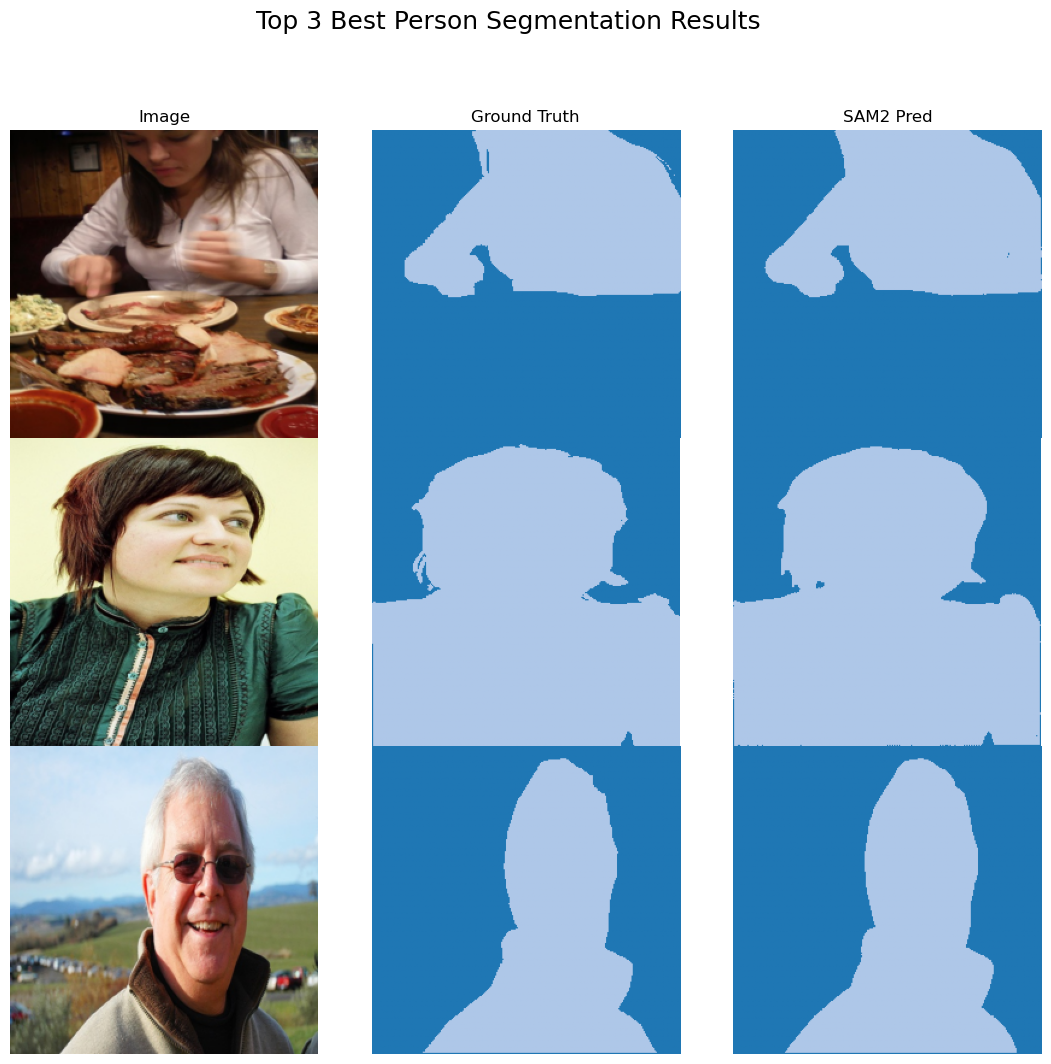

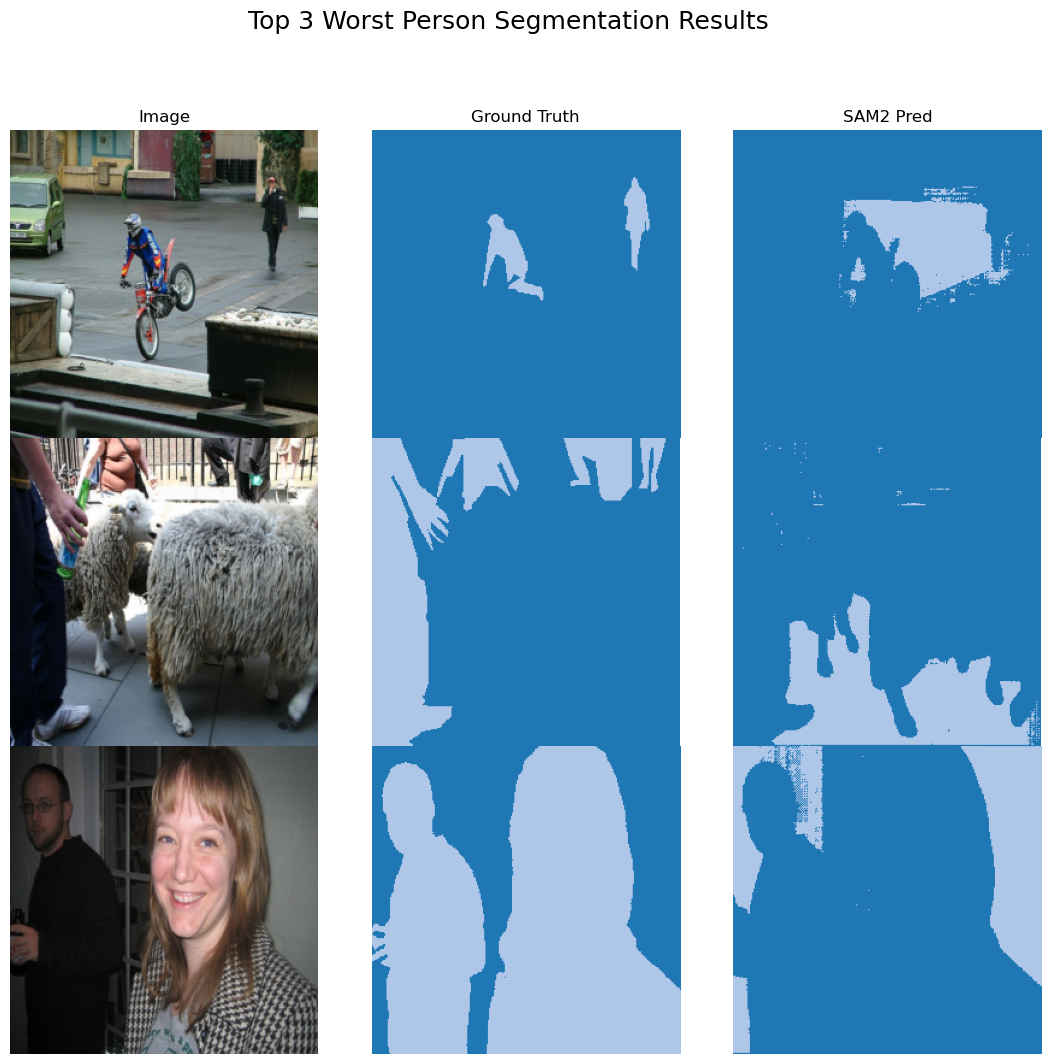

In [33]:
show_sam2_mosaic(best_3, "Top 3 Best Person Segmentation Results")
show_sam2_mosaic(worst_3, "Top 3 Worst Person Segmentation Results")


#### side-by-side

In [41]:
import os
save_dir = "/content/drive/MyDrive/SHBT261/Project2"
os.makedirs(save_dir, exist_ok=True)

unet_ckpt = f"{save_dir}/best_unet_baseline.pth"
deeplab_ckpt = f"{save_dir}/best_deeplabv3plus.pth"

In [34]:
!pip install segmentation-models-pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import InterpolationMode
from scipy.ndimage import binary_erosion, distance_transform_edt
from torchvision.models import resnet50, ResNet50_Weights
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# U-Net Model Definition

class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        # x1: coming from previous layer (upsampled), x2: skip connection
        x1 = self.up(x1)
        # padding if necessary (in case of odd dims)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """Final 1x1 conv to get logits for each class"""
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, num_classes, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, num_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)
        logits = self.outc(x)
        return logits

In [42]:
device = "cuda"

# Load U-Net
unet = UNet(num_classes=21).to(device)
unet.load_state_dict(torch.load(unet_ckpt))
unet.eval()

# Load DeepLabV3+
deeplab = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=21,
).to(device)
deeplab.load_state_dict(torch.load(deeplab_ckpt))
deeplab.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [45]:
def predict_person_unet(unet, img_tensor):
    with torch.no_grad():
        out = unet(img_tensor.unsqueeze(0).to(device))
        pred = out.argmax(1).squeeze().cpu().numpy()
    return (pred == 15).astype(np.uint8)

def predict_person_deeplab(deeplab, img_tensor):
    with torch.no_grad():
        out = deeplab(img_tensor.unsqueeze(0).to(device))  # tensor
        pred = out.argmax(1).squeeze().cpu().numpy()
    return (pred == 15).astype(np.uint8)

In [46]:
def add_other_models_preds(ex):
    img_pil = ex["image"]
    img_tensor = transforms.ToTensor()(img_pil)

    ex["unet_pred"] = predict_person_unet(unet, img_tensor)
    ex["deeplab_pred"] = predict_person_deeplab(deeplab, img_tensor)

    return ex

best_3 = [add_other_models_preds(x) for x in best_3]
worst_3 = [add_other_models_preds(x) for x in worst_3]

In [52]:
def overlay(img, mask, color="red", alpha=0.5):
    img = np.asarray(img).copy()
    c = {"red":(255,0,0), "blue":(0,0,255), "green":(0,255,0)}
    colored = np.zeros_like(img)
    colored[:,:,0] = c[color][0]
    colored[:,:,1] = c[color][1]
    colored[:,:,2] = c[color][2]
    return (img*(1-alpha) + colored*alpha*mask[:,:,None]).astype(np.uint8)


def plot_models_separate(samples, title_text):
    n = len(samples)

    fig, axes = plt.subplots(n, 5, figsize=(22, 4*n))
    fig.suptitle(title_text, fontsize=22)

    col_titles = ["Image", "Ground Truth", "U-Net", "DeepLabV3+", "SAM2"]

    for i, ex in enumerate(samples):
        img = ex["image"]
        gt = overlay(img, ex["gt"],   color="red")
        up = overlay(img, ex["unet_pred"], color="green")
        dp = overlay(img, ex["deeplab_pred"], color="green")
        sp = overlay(img, ex["pred"], color="blue")

        row_imgs = [img, gt, up, dp, sp]

        for j in range(5):
            axes[i, j].imshow(row_imgs[j])

            # Only first row gets titles
            if i == 0:
                if j == 4:
                    axes[i,j].set_title(f"SAM2\nIoU={ex['iou']:.3f}", fontsize=14)
                else:
                    axes[i,j].set_title(col_titles[j], fontsize=14)
            else:
                axes[i,j].set_title("")  # No title for other rows

            axes[i,j].axis("off")

    plt.tight_layout()
    plt.show()


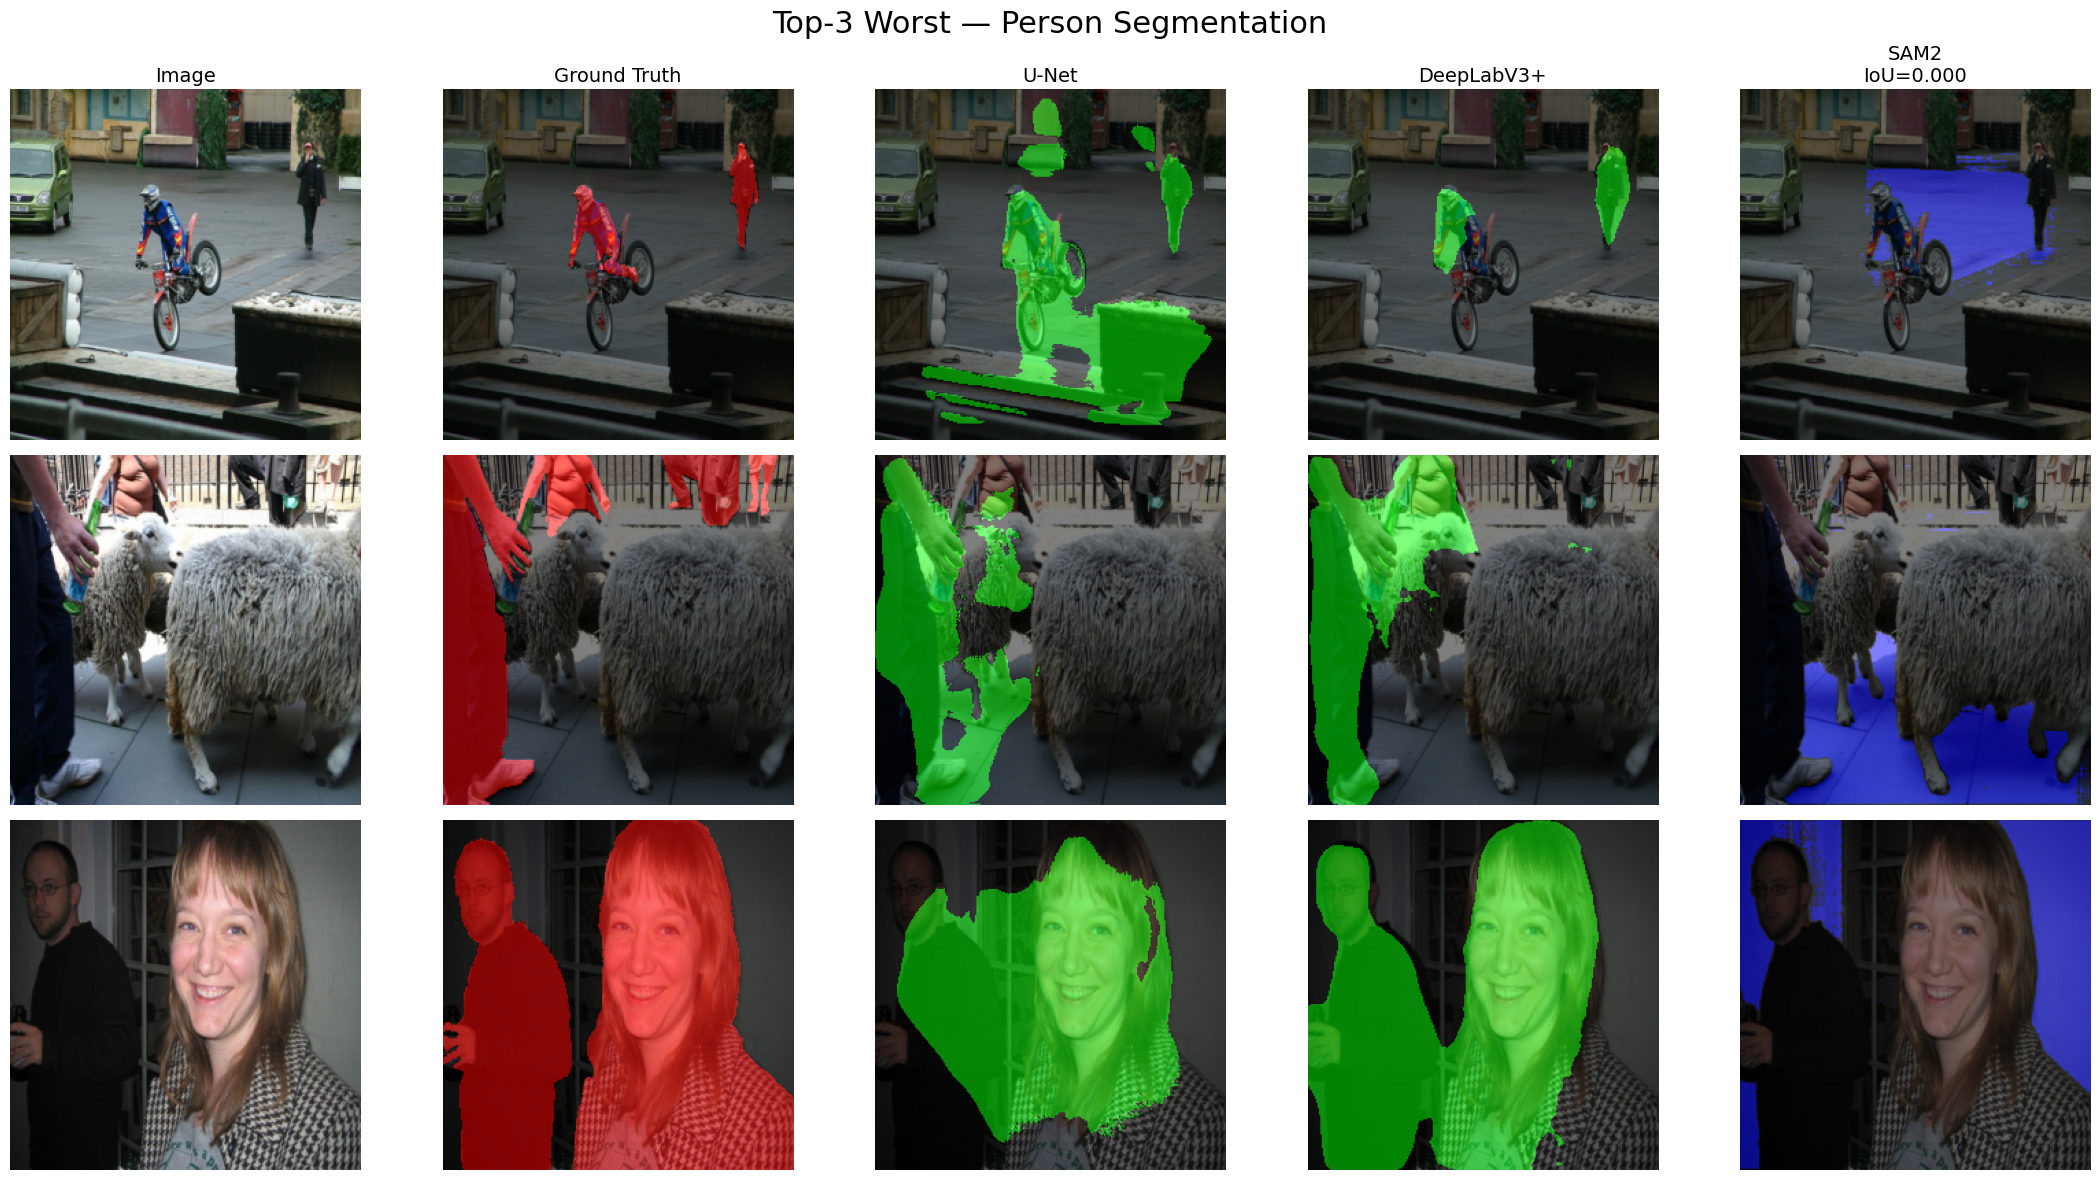

In [53]:
plot_models_separate(worst_3, "Top-3 Worst — Person Segmentation")

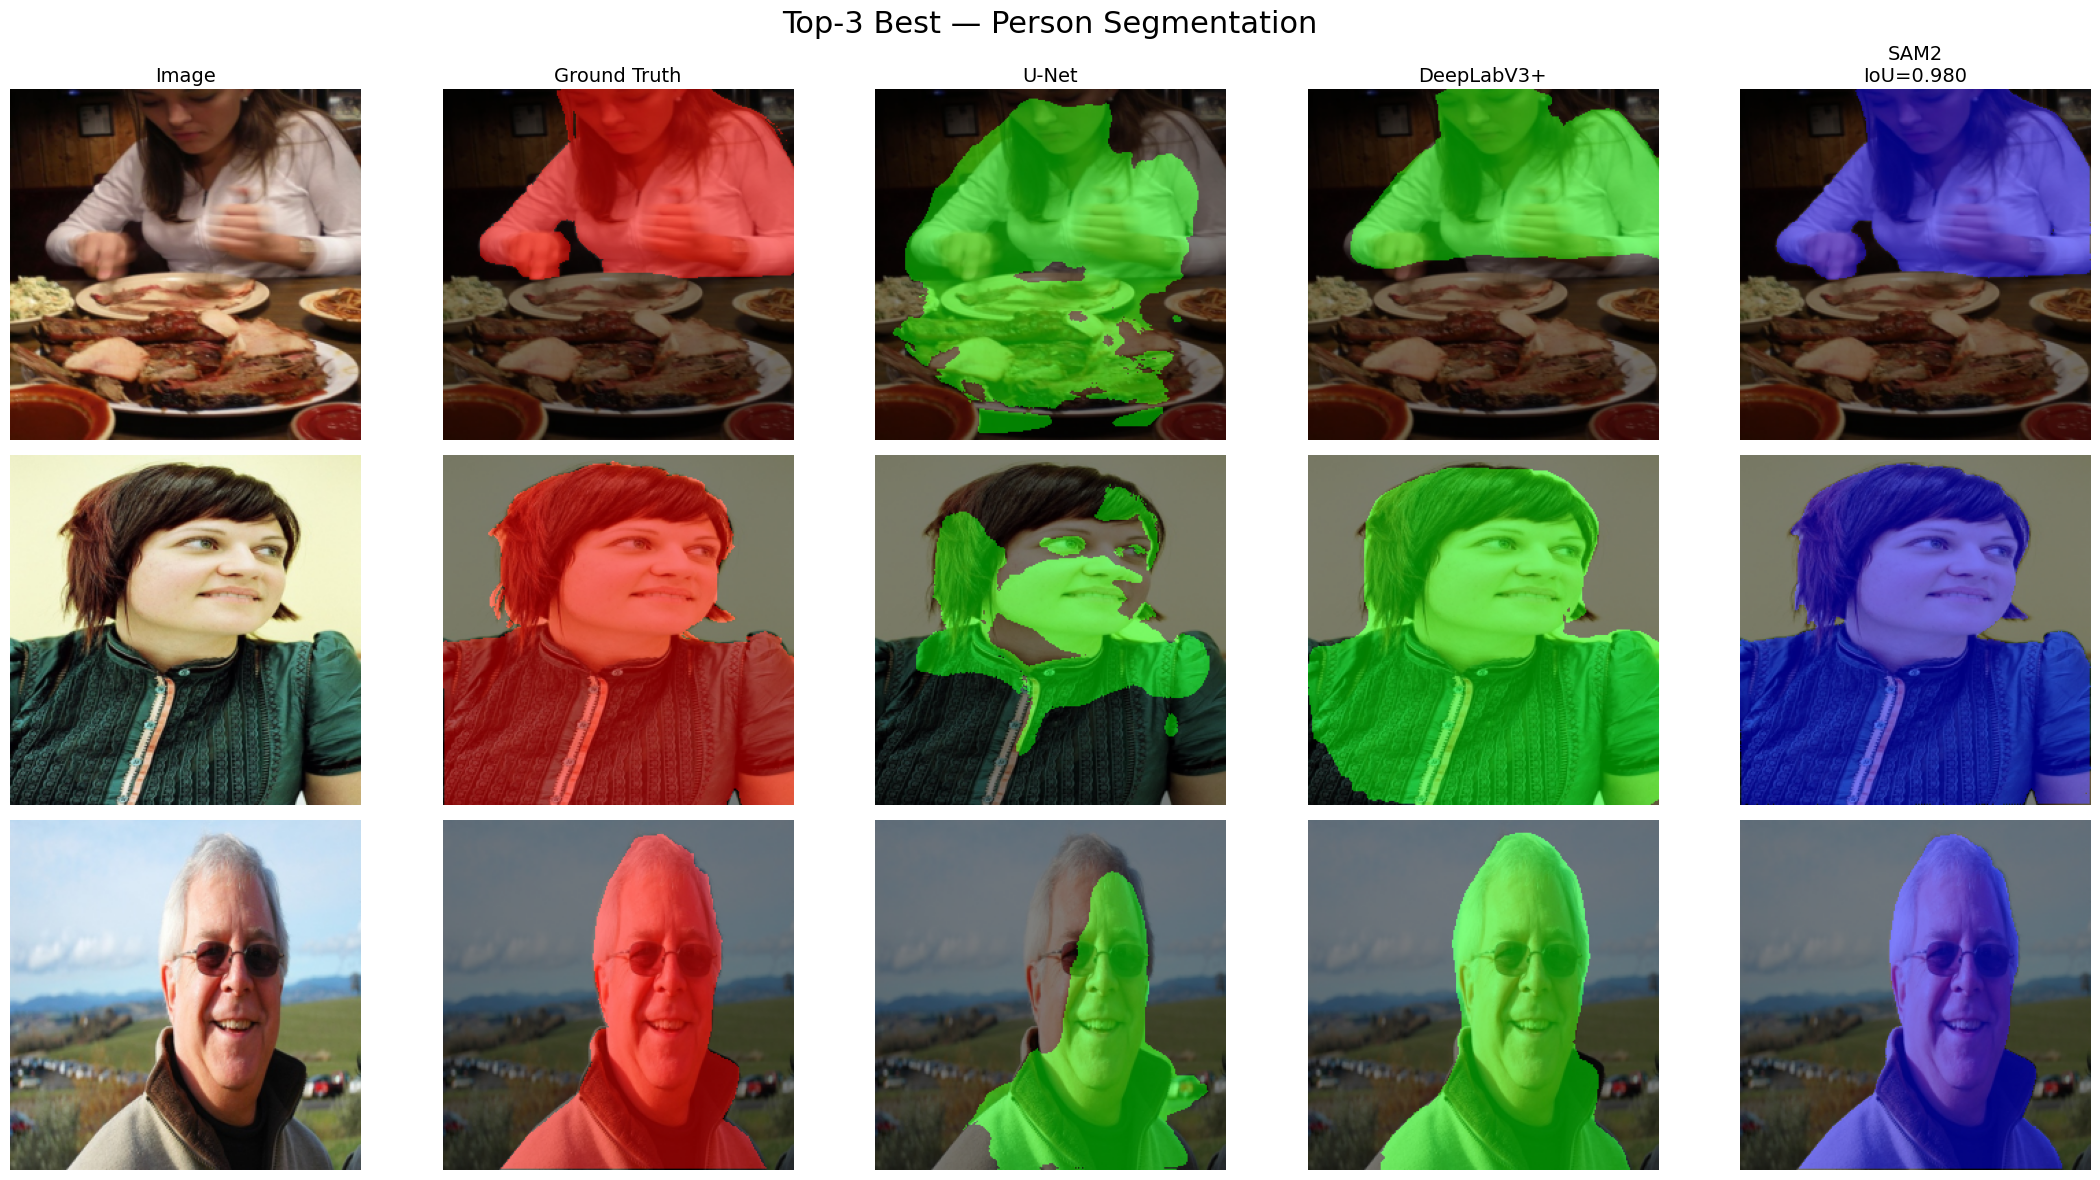

In [54]:
plot_models_separate(best_3,  "Top-3 Best — Person Segmentation")